# Analysis of Daily Historical Future Variables from LOCA and BCSD

This notebook analyzes daily hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. The daily datasets are used here to assess the statistical extremes ($RO_{20yr}$ and $7RO10$).

Variables include:
- Total Runoff

In [1]:
from loca import print_date
print_date()

Last executed: 2018-02-11 19:31:18.969611 by jhamman on r8i4n0


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_daily_cmip_hydro_datasets
from loca.utils import calc_change

models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['CCSM4', 'CNRM-CM5']

hydro_vars = ['ET', 'total_runoff']

In [3]:
from dask.distributed import Client
client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client

Client Scheduler: tcp://10.148.7.109:44951 Dashboard: http://10.148.7.109:8787/status,Cluster Workers: 18 Cores: 72 Memory: 324.00 GB


# Load Data

In [4]:
hist_data = load_daily_cmip_hydro_datasets('historical', models=models, autoclose=True)
rcp4_data = load_daily_cmip_hydro_datasets('rcp45', models=models, autoclose=True)
rcp8_data = load_daily_cmip_hydro_datasets('rcp85', models=models, autoclose=True)

load_daily_cmip_hydro_datasets
load_daily_loca_hydrology


100%|██████████| 6/6 [02:45<00:00, 27.53s/it]

load_daily_bcsd_hydrology
load_bcsd_dataset



100%|██████████| 6/6 [01:18<00:00, 13.02s/it]

load_daily_cmip_hydro_datasets
load_daily_loca_hydrology



100%|██████████| 6/6 [04:30<00:00, 45.09s/it]


load_daily_bcsd_hydrology
load_bcsd_dataset


100%|██████████| 6/6 [02:04<00:00, 20.80s/it]

load_daily_cmip_hydro_datasets
load_daily_loca_hydrology



100%|██████████| 6/6 [04:29<00:00, 44.94s/it]


load_daily_bcsd_hydrology
load_bcsd_dataset


100%|██████████| 6/6 [02:05<00:00, 20.93s/it]


In [5]:
hist_epoch = slice('1979-10-01', '1999-09-30')
futr_epoch = slice('2079-10-01', '2099-09-30')

In [6]:
import numpy as np
from scipy.stats import pearson3

# def calc_extreme_gufunc(vals, q=0.5):
#     '''at = 1 - 1.0/(nyear*365.25)'''
#     params = pearson3.fit(vals)
#     return pearson3.ppf(at, *params)


# def calc_extreme(vals, q):
#     return xr.apply_ufunc(calc_extreme_gufunc, vals,
#                           dask='parallelized', vectorize=True,
#                           kwargs=dict(q=q),
#                           input_core_dims=[['time']],
#                           output_dtypes=[vals.dtype],
#                           keep_attrs=True)


def calc_extreme_gufunc(vals, q=0.5, axis=-1):
    return np.nanpercentile(vals, q=q * 100, axis=axis)

def calc_extreme(vals, q):
    return xr.apply_ufunc(calc_extreme_gufunc, vals,
                          dask='parallelized',
                          kwargs=dict(axis=-1, q=q),
                          input_core_dims=[['time']],
                          output_dtypes=[vals.dtype],
                          keep_attrs=True)

    

In [13]:
import numpy as np

In [41]:
def calc_ro20yr(da, q=1 - 1./20.):
    chunks = {'lat': 50, 'lon': 50, 'time': 366}
    ymax = da.chunk(chunks).resample(time='A-OCT').max('time')
    ymax = ymax.persist().chunk({'time': len(ymax['time']), 'gcm': 1, 'lat': 50, 'lon': 50})
    return calc_extreme(ymax, q=q)


def calc_7ro10(da, q=1 - 1./10.):
    weekly_ro = da.resample(time='7D').mean('time')
    ymin = weekly_ro.resample(time='A-OCT').min('time')
    ymin = ymin.chunk({'time': len(ymin['time']), 'gcm': 1, 'lat': 50, 'lon': 50})
    return calc_extreme(ymin, q=q)

In [42]:
mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()


In [44]:
var = 'total_runoff'

plot_data = {}


for stat, func in [('$RO_{20yr}$', calc_ro20yr)]: #, ('$7RO10$', calc_7ro10)]:
    print(stat, flush=True)
    plot_data[stat] = {}
#     plot_data[stat]['Historical'] = {}
#     for k, ds in hist_data.items():
#         print(k, flush=True)
# #         with dask.set_options(get=dask.get):
#         plot_data[stat]['Historical'][k] = func(ds[var].sel(time=hist_epoch)).compute()
#         break
           
    plot_data[stat]['Historical'] = dict((k, func(ds[var].sel(time=hist_epoch)).compute()) for (k, ds) in hist_data.items())
    plot_data[stat]['RCP 4.5'] = dict((k, func(ds[var].sel(time=futr_epoch)).compute()) for (k, ds) in rcp4_data.items())
    plot_data[stat]['RCP 8.5'] = dict((k, func(ds[var].sel(time=futr_epoch)).compute()) for (k, ds) in rcp8_data.items())


$RO_{20yr}$


distributed.client - WARNING - Couldn't gather keys {"('calc_extreme_gufunc-3918ff631c1b8d9848c012ab854140b6', 2, 1, 8)": ['tcp://10.148.11.0:34862']}


# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

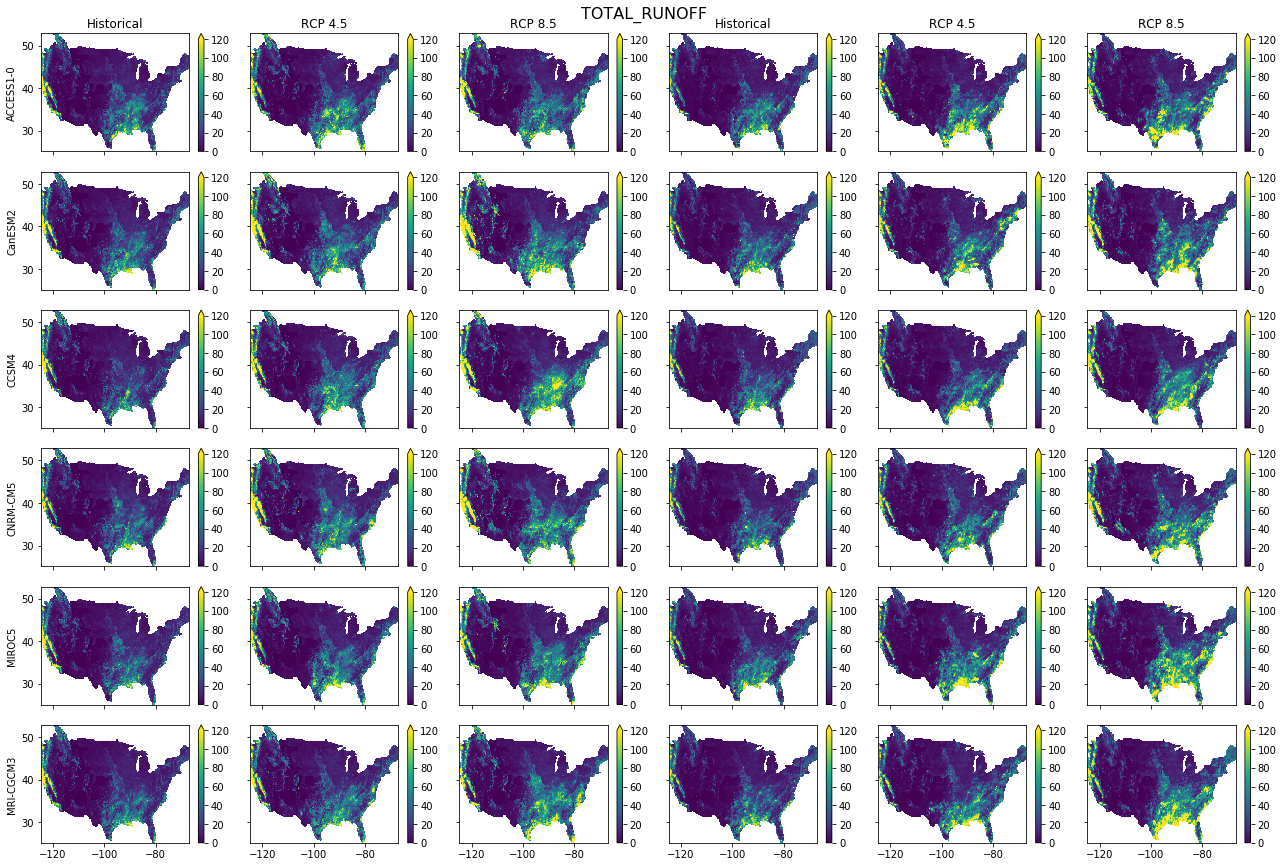

In [46]:
kwargs = {'$RO_{20yr}$': {'vmin': 0, 'vmax': 120},
          '$7RO10$': {'vmin': 0, 'vmax': 0.6}}

var = 'total_runoff'
subcols = ['Historical', 'RCP 4.5', 'RCP 8.5']

# TODO: Fix mask issue with LOCA

for stat, data in plot_data.items():

    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, title in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                data[title][dset].sel(gcm=model).where(mask).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[stat])
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()    


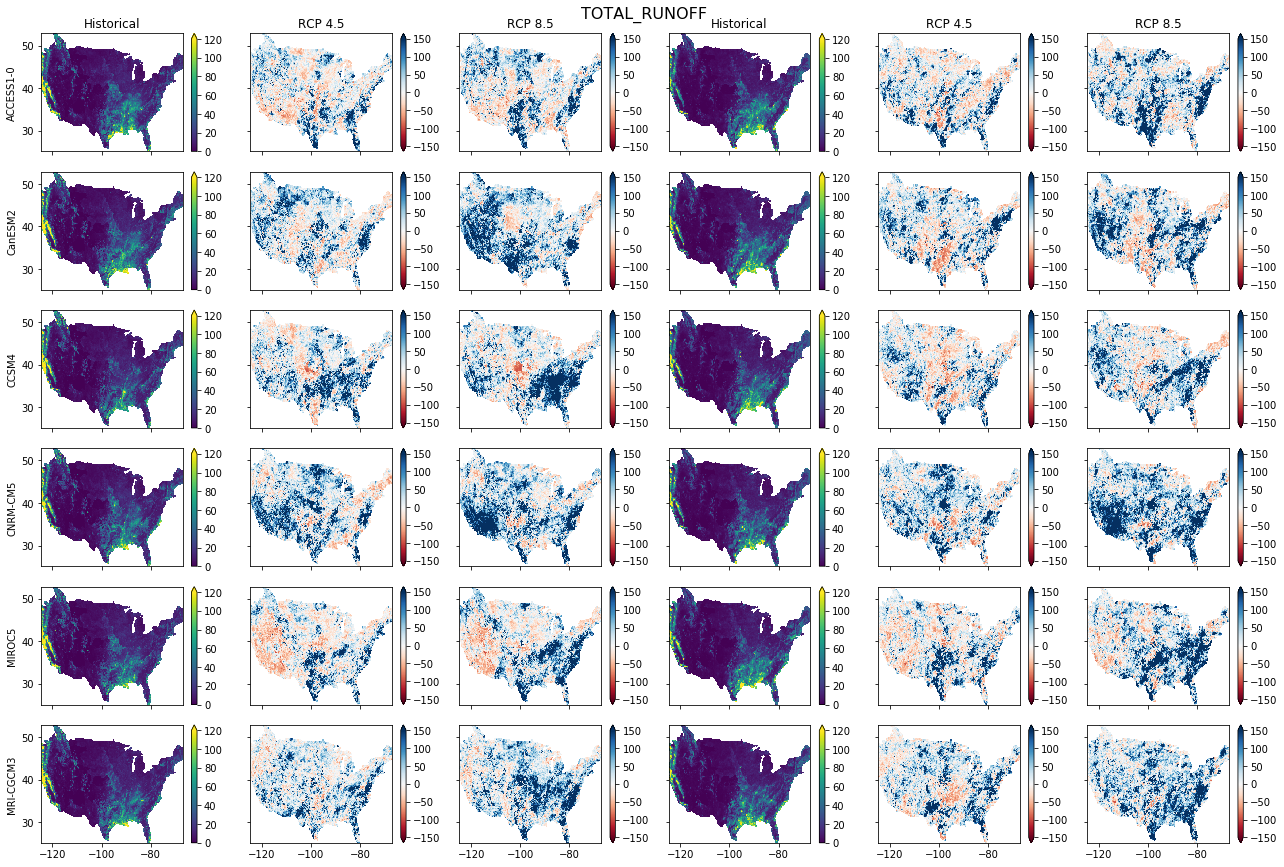

In [48]:
diff_kws = {'$RO_{20yr}$': {'vmin': -150, 'vmax': 150, 'cmap': 'RdBu', 'extend': 'both'},
            '$7RO10$': {'vmin': -0.1, 'vmax': 0.1, 'cmap': 'RdBu', 'extend': 'both'}}

for stat, data in plot_data.items():

    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, title in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                if 'RCP' in title:
                    change = calc_change(data['Historical'][dset].sel(gcm=model), data[title][dset].sel(gcm=model), pct=True).persist()
                    change.where(mask).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[stat])
                else:
                    data[title][dset].sel(gcm=model).where(mask).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[stat])

                    
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()    


In [49]:
inds = np.nonzero(mask.values)
inds


(array([  0,   0,   0, ..., 221, 221, 221]),
 array([349, 350, 351, ...,  45,  46,  47]))

Text(0.5,0,'LOCA')

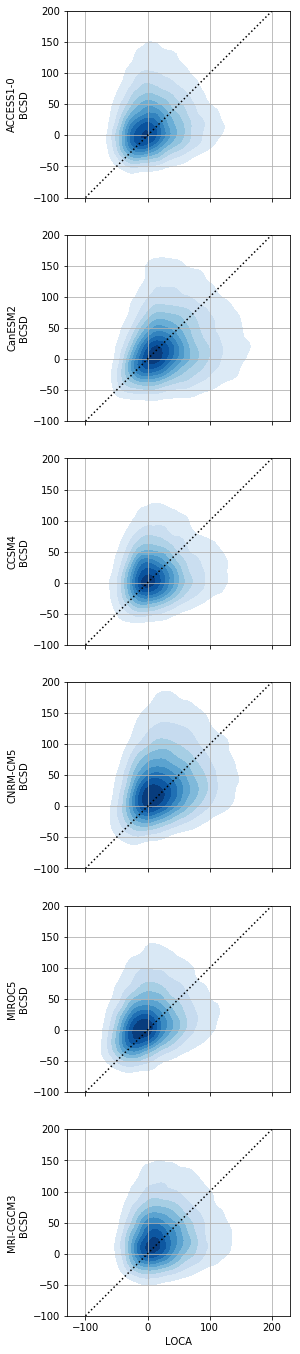

In [52]:
import seaborn as sns

fig, axes = plt.subplots(nrows=len(models), sharex=True, sharey=True, subplot_kw=dict(aspect='equal'), figsize=(4, 4*len(models)))
for i, model in enumerate(models):
    ax = axes[i]
    
    bcsd_change = calc_change(data['Historical']['bcsd'].sel(gcm=model), data['RCP 8.5']['bcsd'].sel(gcm=model), pct=True).load()
    loca_change = calc_change(data['Historical']['loca'].sel(gcm=model), data['RCP 8.5']['loca'].sel(gcm=model), pct=True).load()

    ax.plot([-100, 200], [-100, 200], 'k:')
    sns.kdeplot(bcsd_change.fillna(0).values[inds],
                loca_change.fillna(0).values[inds],
                cmap="Blues", shade=True,
                shade_lowest=False,
                clip=(-100, 500), ax=ax)
    
    ax.set_xlim([-100, 200])
    ax.set_ylim([-100, 200])
    ax.set_ylabel(model + '\nBCSD')
    ax.grid()
ax.set_xlabel('LOCA')


In [ ]:
plt.close('all')